# 1. Classification

In [1]:
import sys
sys.path.append('../Utils')
from pre_processing import *

In [2]:
import random
import scipy
from scipy.io import arff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import scikitplot as skplt
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import label_binarize
from sklearn import datasets 
from sklearn.impute import SimpleImputer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import *
from sklearn.metrics import *


## Plot ROC and PR curves

In [3]:
def plot_all(X_test, y_test, all_clfs, clf_names, file_name):
    plt.figure(figsize=(16,8))
    plt.suptitle("Dataset: %s"%file_name, size=16)
    plt.subplot(121)
    roc_scores = plot_roc_curve(X_test, y_test, all_clfs, clf_names)
    plt.subplot(122)
    pr_scores = plot_pr_curve(X_test, y_test, all_clfs, clf_names)
    plt.savefig(image_path+file.split('.')[0]+'-roc_pr')
    plt.show()
    return roc_scores, pr_scores

#plot tools
def plot_roc_curve(X_test, y_test, all_clfs, clf_names):
    roc_scores = dict()
#     plt.figure(figsize=(10,8))
    plt.title('Receiver Operating Characteristic')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1.0])
    plt.ylim([0, 1.02])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    np.random.seed(0)
    y_test = label_binarize(y_test, classes=np.unique(y_test))
    n_classes = y_test.shape[1]

    for clf, clf_name in zip(all_clfs, clf_names):
        #two classes 
        if n_classes <= 2:
            probs = clf.predict_proba(X_test)
            preds = probs[:,1]
            fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, preds)
            roc_auc = sklearn.metrics.auc(fpr, tpr)
            roc_scores[clf_name] = roc_auc
            plt.plot(fpr, tpr, 'b', label = '%s (AUC = %0.3f)' % (clf_name,roc_auc), c=np.random.rand(3,))
            plt.legend(loc = 'lower right')         
        #multi classes
        else:
            y_score = clf.predict_proba(X_test)
            # Compute ROC curve and ROC area for each class
            fpr = dict()
            tpr = dict()
            roc_auc = dict()
            for i in range(n_classes):
                fpr[i], tpr[i], _ = sklearn.metrics.roc_curve(y_test[:,i],y_score[:,i])
                roc_auc[i] = sklearn.metrics.auc(fpr[i], tpr[i])
            # Compute micro-average ROC curve and ROC area
            fpr["micro"], tpr["micro"], _ = sklearn.metrics.roc_curve(y_test.ravel(),y_score.ravel())
            roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
            roc_scores[clf_name] = roc_auc["micro"]
            plt.plot(fpr["micro"], tpr["micro"], 'b', label = '%s (Micro AUC = %0.3f)' % 
                     (clf_name,roc_auc["micro"]), c=np.random.rand(3,))
            plt.legend(loc = 'lower right')        
    return roc_scores

def plot_pr_curve(X_test, y_test, all_clfs, clf_names):
    pr_scores = dict()
#     plt.figure(figsize=(10,8))
    plt.title('Precision-Recall Curve')
    plt.plot([0, 1], [1, 0],'r--')
    plt.xlim([0, 1.0])
    plt.ylim([0, 1.02])
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    np.random.seed(0)
    y_test = label_binarize(y_test, classes=np.unique(y_test))
    n_classes = y_test.shape[1]
    
    for clf, clf_name in zip(all_clfs, clf_names):
        #two classes
        if n_classes <= 2:
            probs = clf.predict_proba(X_test)
            preds = probs[:,1]
            precision, recall, _ = sklearn.metrics.precision_recall_curve(y_test, preds)
            pr_auc = sklearn.metrics.auc(recall, precision)
            pr_scores[clf_name] = pr_auc
            plt.plot(recall, precision, 'b', label = '%s (AUC = %0.3f)' % (clf_name,pr_auc), c=np.random.rand(3,))
            plt.legend(loc = 'lower left')
        #multi classes
        else:
            y_score = clf.predict_proba(X_test)
            # Compute ROC curve and ROC area for each class
            precision = dict()
            recall = dict()
            pr_auc = dict()
            for i in range(n_classes):
                precision[i], recall[i], _ = sklearn.metrics.precision_recall_curve(y_test[:,i],y_score[:,i])
                pr_auc[i] = sklearn.metrics.auc(recall[i], precision[i])
            # Compute micro-average ROC curve and ROC area
            precision["micro"], recall["micro"], _ = sklearn.metrics.precision_recall_curve(y_test.ravel(),y_score.ravel())
            pr_auc["micro"] = sklearn.metrics.auc(recall["micro"], precision["micro"])  
            pr_scores[clf_name] = pr_auc["micro"]
            plt.plot(recall["micro"], precision["micro"], 'b', label = '%s (Micro AUC = %0.3f)' % 
                     (clf_name,pr_auc["micro"]), c=np.random.rand(3,))
            plt.legend(loc = 'lower left')
    return pr_scores

## Pre-porcessing

import from Utils folder

## Models

In [4]:
# classifiers
def train_KNN(X_train, y_train):
    print('Training KNN ...')
    knn = KNeighborsClassifier()
#     scoring = ['roc_auc']
    param_distributions = {
        'n_neighbors' : scipy.stats.randint(1,20)
    }
    randcv = sklearn.model_selection.RandomizedSearchCV(
        knn,param_distributions,n_iter=20,cv=3,n_jobs=-1,random_state=0)
    randcv.fit(X_train, y_train)
    return randcv.best_estimator_

def train_SVM(X_train, y_train):
    print('Training SVM ...')
    svm = SVC(kernel='rbf', probability=True, cache_size=3000, random_state=0)
#     scoring = ['roc_auc']
    param_distributions = {
        'C' : scipy.stats.reciprocal(1.0, 100.),
        'gamma' : scipy.stats.reciprocal(0.01, 10.),
    }
    randcv = sklearn.model_selection.RandomizedSearchCV(
        svm,param_distributions,n_iter=20,cv=3,n_jobs=-1,random_state=0)
    randcv.fit(X_train, y_train)
    return randcv.best_estimator_

def train_DecisionTree(X_train, y_train):
    print('Training DecisionTree ...')
    tree = DecisionTreeClassifier(random_state=0)
#     scoring = ['roc_auc']
    param_distributions = {
        'max_depth' : scipy.stats.randint(10,1000)
    }
    randcv = sklearn.model_selection.RandomizedSearchCV(
        tree,param_distributions,n_iter=30,cv=3,n_jobs=-1,random_state=0)
    randcv.fit(X_train, y_train)
    return randcv.best_estimator_

def train_RandomForest(X_train, y_train):
    print('Training RandomForest ...')
    forest = RandomForestClassifier(random_state=0)
#     scoring = ['roc_auc']
    param_distributions = {
        'max_depth' : scipy.stats.randint(10,100),
        'n_estimators' : scipy.stats.randint(100,1000)
    }
    randcv = sklearn.model_selection.RandomizedSearchCV(
        forest,param_distributions,n_iter=10,cv=3,n_jobs=-1,random_state=0)
    randcv.fit(X_train, y_train)
    return randcv.best_estimator_

def train_AdaBoost(X_train, y_train):
    print('Training AdaBoost ...')
    boost = AdaBoostClassifier(random_state=0)
#     scoring = ['roc_auc']
    param_distributions = {
        'learning_rate' : scipy.stats.uniform(0.75, 1.25),
        'n_estimators' : scipy.stats.randint(40,70)
    }
    randcv = sklearn.model_selection.RandomizedSearchCV(
        boost,param_distributions,n_iter=30,cv=3,n_jobs=-1,random_state=0)
    randcv.fit(X_train, y_train)
    return randcv.best_estimator_    

def train_LogisticRegression(X_train, y_train):
    print('Training LogisticRegression ...')
    lr = LogisticRegression(solver='liblinear', multi_class='auto', random_state=0)
#     scoring = ['roc_auc']
    param_distributions = {
        'C' : scipy.stats.reciprocal(1.0, 1000.),
        'max_iter' : scipy.stats.randint(100,1000)
    }
    randcv = sklearn.model_selection.RandomizedSearchCV(
        lr,param_distributions,n_iter=30,cv=3,n_jobs=-1,random_state=0)
    randcv.fit(X_train, y_train)
    return randcv.best_estimator_ 

def train_GaussianNaiveBayes(X_train, y_train):
    print('Training GaussianNaiveBayes ...')
    gaussian = GaussianNB()
#     scoring = ['roc_auc']
    param_distributions = {
        'var_smoothing' : scipy.stats.uniform(1e-10, 1e-9),
    }
    randcv = sklearn.model_selection.RandomizedSearchCV(
        gaussian,param_distributions,n_iter=30,cv=3,n_jobs=-1,random_state=0)
    randcv.fit(X_train, y_train)
    return randcv.best_estimator_ 

def train_NeuralNetwork(X_train, y_train):
    print('Training NeuralNetwork ...')
    nn = MLPClassifier(solver='adam', random_state=0)
#     scoring = ['roc_auc']
    param_distributions = {
        'hidden_layer_sizes' : [(100,50,10)],
        'learning_rate_init' : scipy.stats.uniform(0.001, 0.005),
        'max_iter' : scipy.stats.randint(200,500)
    }
    randcv = sklearn.model_selection.RandomizedSearchCV(
        nn,param_distributions,n_iter=10,cv=3,n_jobs=-1,random_state=0)
    randcv.fit(X_train, y_train)
    return randcv.best_estimator_ 

In [5]:
def run_all_clfs(X_train, y_train, X_test, y_test):
    all_clfs = []
    clf_names = []

    clf1 = train_KNN(X_train, y_train)
    all_clfs.append(clf1)
    clf_names.append('KNN')

    clf2 = train_SVM(X_train, y_train)
    all_clfs.append(clf2)
    clf_names.append('SVM')

    clf3 = train_DecisionTree(X_train, y_train)
    all_clfs.append(clf3)
    clf_names.append('Decision Tree')

    clf4 = train_RandomForest(X_train, y_train)
    all_clfs.append(clf4)
    clf_names.append('Random Forest')

    clf5 = train_AdaBoost(X_train, y_train)
    all_clfs.append(clf5)
    clf_names.append('AdaBoost')

    clf6 = train_LogisticRegression(X_train, y_train)
    all_clfs.append(clf6)
    clf_names.append('Logistic regression')

    clf7 = train_GaussianNaiveBayes(X_train, y_train)
    all_clfs.append(clf7)
    clf_names.append('Gaussian Naive Bayes')

    clf8 = train_NeuralNetwork(X_train, y_train)
    all_clfs.append(clf8)
    clf_names.append('NeuralNetwork')

    return all_clfs, clf_names

In [6]:
def make_classification(file, df, df_test):
    print("Dataset : %s" % file)
    #     df.info()
    check_class_distribution(df)
    df = replace_question_marks(df)
    df_test = replace_question_marks(df_test)
    
    X = df.iloc[:,:-1]
    y = df.iloc[:,-1]
    assert len(y.shape) == 1, "wrong shape of y"

    if type(df_test) == type(None):
        print('No default test set, dataset splitted')
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)
    else:
        print('Loaded given test set')
        X_train = X
        y_train = y
        X_test = df_test.iloc[:,:-1]
        y_test = df_test.iloc[:,-1]      

    X_train, X_test = encode_labels(X_train,X_test)
    X_train, X_test = dimension_reduction(X_train,X_test)

    #     X_train, X_test = impute_value(X_train, X_test, strategy = 'most_frequent')
    X_train, X_test = impute_value(X_train, X_test,strategy = 'mean')
    X_train, X_test = normalize_data(X_train, X_test)

    y_train, y_test = encode_labels(y_train, y_test, -1)

    all_clfs, clf_names = run_all_clfs(X_train, y_train, X_test, y_test)
    roc_scores, pr_scores = plot_all(X_test, y_test, all_clfs, clf_names, file)
    return roc_scores, pr_scores

## Data sets

In [7]:
data_path = 'dataset/'
image_path = 'image/'

file1 = 'messidor_features.arff'
data1 = arff.loadarff(data_path+file1)
df1 = pd.DataFrame(data1[0])

file2 = 'default of credit card clients.xls'
df2 = pd.read_excel(data_path+file2,index_col=0,header=1)
df2 = df2.sample(5000,random_state=0)

file3 = 'breast-cancer-wisconsin.data'
df3 = pd.read_csv(data_path+file3,header=None, index_col=0)
df3 = df3[df3[6]!='?'].astype('int64')

file3_2 = 'wdbc.data'
df3_2 = pd.read_csv(data_path+file3_2,header=None, index_col=0)
df3_2 = reorder_columns(df3_2)

file3_3 = 'wpbc.data'
df3_3 = pd.read_csv(data_path+file3_3,header=None, index_col=0)
df3_3 = reorder_columns(df3_3)
df3_3 = df3_3[df3_3[34]!='?']
df3_3[34] = df3_3[34].astype('int64')

file4 = 'australian.dat'
df4 = pd.read_csv(data_path+file4,header=None,sep=' ')
df4 = reorder_columns(df4)

file5 = 'german.data-numeric'
df5 = pd.read_csv(data_path+file5,header=None,sep=' +', engine='python')

#multi-class
file6 = 'Faults.NNA'
df6 = pd.read_csv(data_path+file6,header=None,sep='\t', engine='python')
cats  = df6.iloc[:,-7:].idxmax(axis=1)
df6 = df6.drop(df6.columns[-7:], axis=1)
df6['class'] = cats

file7 = 'adult.data'
file7_test = 'adult.test'
df7 = pd.read_csv(data_path+file7,header=None,sep=', ', engine='python')
df7 = df7.sample(5000, random_state=0)
df7_test = pd.read_csv(data_path+file7_test,header=None,sep=', ', engine='python',skiprows=1)

#multi-class
file8 = 'yeast.data'
df8 = pd.read_csv(data_path+file8,header=None,sep=' +', index_col=0, engine='python')

#error dataset
file9 = 'ThoraricSurgery.arff'
data9 = arff.loadarff(data_path+file9)
df9 = pd.DataFrame(data9[0])

file10 = 'seismic-bumps.arff'
data10, meta = arff.loadarff(data_path+file10)
df10 = pd.DataFrame(data10)

Dataset : messidor_features.arff
Class distributions:
Class
b'1'    611
b'0'    540
Name: count, dtype: int64
Replaced all '?' to np.nan
No question marks found
No default test set, dataset splitted
Encoding X features
Normalized data by scaler: <class 'sklearn.preprocessing._data.MinMaxScaler'>
Encoding y label values
Training KNN ...
Training SVM ...
Training DecisionTree ...


C:\Users\SANJEEV KUMAR\AppData\Roaming\Python\Python312\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Training RandomForest ...
Training AdaBoost ...


C:\Users\SANJEEV KUMAR\AppData\Roaming\Python\Python312\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Training LogisticRegression ...


C:\Users\SANJEEV KUMAR\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Training GaussianNaiveBayes ...
Training NeuralNetwork ...


C:\Users\SANJEEV KUMAR\AppData\Local\Temp\ipykernel_6748\1517101872.py:34: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(fpr, tpr, 'b', label = '%s (AUC = %0.3f)' % (clf_name,roc_auc), c=np.random.rand(3,))
C:\Users\SANJEEV KUMAR\AppData\Local\Temp\ipykernel_6748\1517101872.py:34: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(fpr, tpr, 'b', label = '%s (AUC = %0.3f)' % (clf_name,roc_auc), c=np.random.rand(3,))
C:\Users\SANJEEV KUMAR\AppData\Local\Temp\ipykernel_6748\1517101872.py:34: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(fpr, tpr, 'b', label = '%s (AUC = %0.3f)' % (clf_name,roc

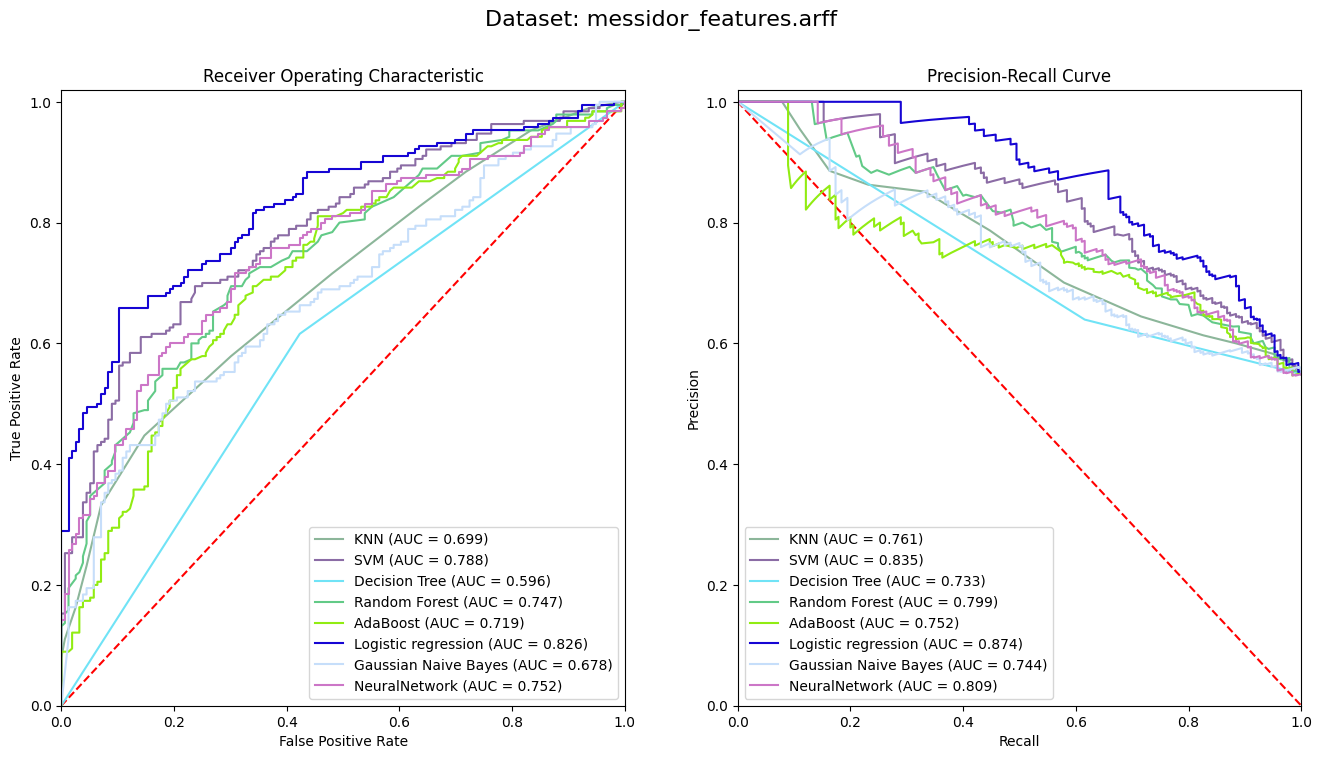

Dataset : default of credit card clients.xls
Class distributions:
default payment next month
0    3915
1    1085
Name: count, dtype: int64
Replaced all '?' to np.nan
No question marks found
No default test set, dataset splitted
Encoding X features
Normalized data by scaler: <class 'sklearn.preprocessing._data.MinMaxScaler'>
Encoding y label values
Training KNN ...
Training SVM ...
Training DecisionTree ...
Training RandomForest ...
Training AdaBoost ...


C:\Users\SANJEEV KUMAR\AppData\Roaming\Python\Python312\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Training LogisticRegression ...


C:\Users\SANJEEV KUMAR\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Training GaussianNaiveBayes ...
Training NeuralNetwork ...


C:\Users\SANJEEV KUMAR\AppData\Local\Temp\ipykernel_6748\1517101872.py:34: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(fpr, tpr, 'b', label = '%s (AUC = %0.3f)' % (clf_name,roc_auc), c=np.random.rand(3,))
C:\Users\SANJEEV KUMAR\AppData\Local\Temp\ipykernel_6748\1517101872.py:34: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(fpr, tpr, 'b', label = '%s (AUC = %0.3f)' % (clf_name,roc_auc), c=np.random.rand(3,))
C:\Users\SANJEEV KUMAR\AppData\Local\Temp\ipykernel_6748\1517101872.py:34: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(fpr, tpr, 'b', label = '%s (AUC = %0.3f)' % (clf_name,roc

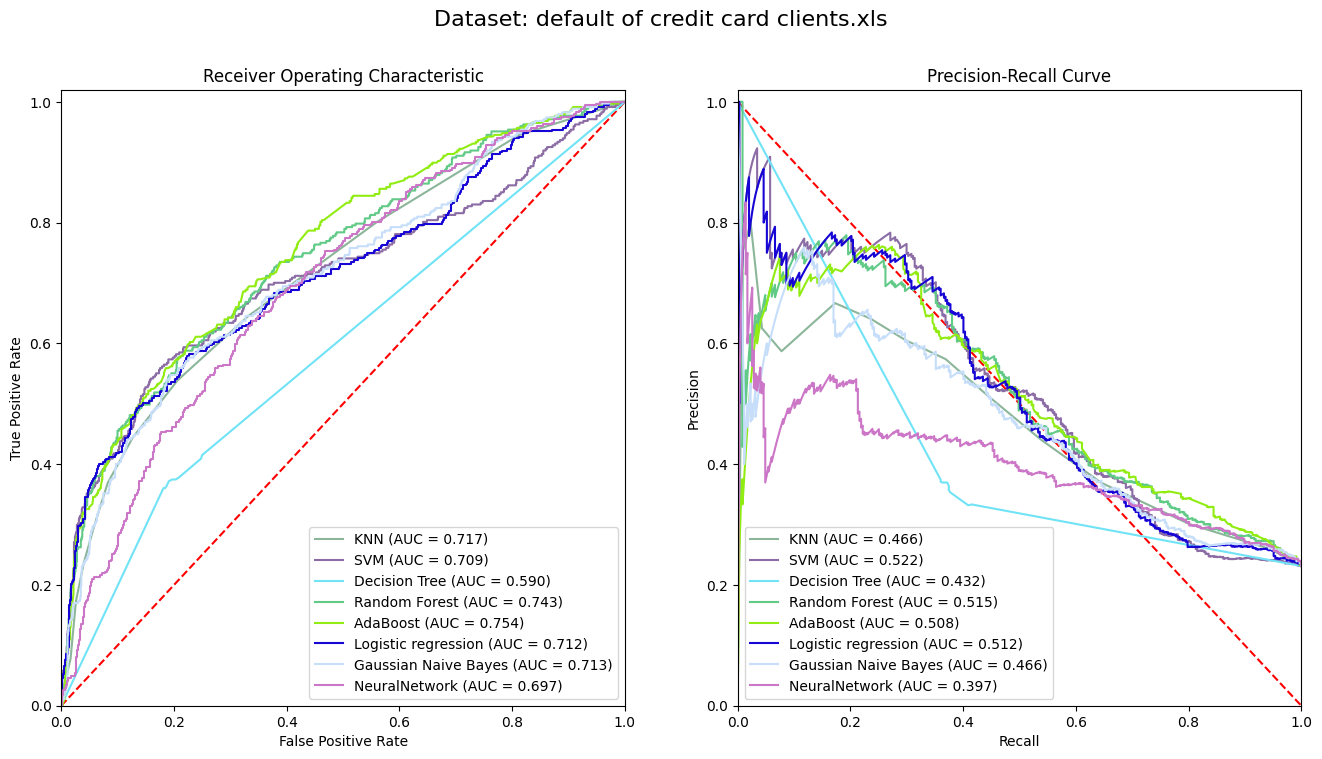

Dataset : breast-cancer-wisconsin.data
Class distributions:
10
2    444
4    239
Name: count, dtype: int64
Replaced all '?' to np.nan
No question marks found
No default test set, dataset splitted
Encoding X features
Normalized data by scaler: <class 'sklearn.preprocessing._data.MinMaxScaler'>
Encoding y label values
Training KNN ...
Training SVM ...
Training DecisionTree ...
Training RandomForest ...
Training AdaBoost ...


C:\Users\SANJEEV KUMAR\AppData\Roaming\Python\Python312\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Training LogisticRegression ...
Training GaussianNaiveBayes ...


C:\Users\SANJEEV KUMAR\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Training NeuralNetwork ...


C:\Users\SANJEEV KUMAR\AppData\Local\Temp\ipykernel_6748\1517101872.py:34: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(fpr, tpr, 'b', label = '%s (AUC = %0.3f)' % (clf_name,roc_auc), c=np.random.rand(3,))
C:\Users\SANJEEV KUMAR\AppData\Local\Temp\ipykernel_6748\1517101872.py:34: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(fpr, tpr, 'b', label = '%s (AUC = %0.3f)' % (clf_name,roc_auc), c=np.random.rand(3,))
C:\Users\SANJEEV KUMAR\AppData\Local\Temp\ipykernel_6748\1517101872.py:34: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(fpr, tpr, 'b', label = '%s (AUC = %0.3f)' % (clf_name,roc

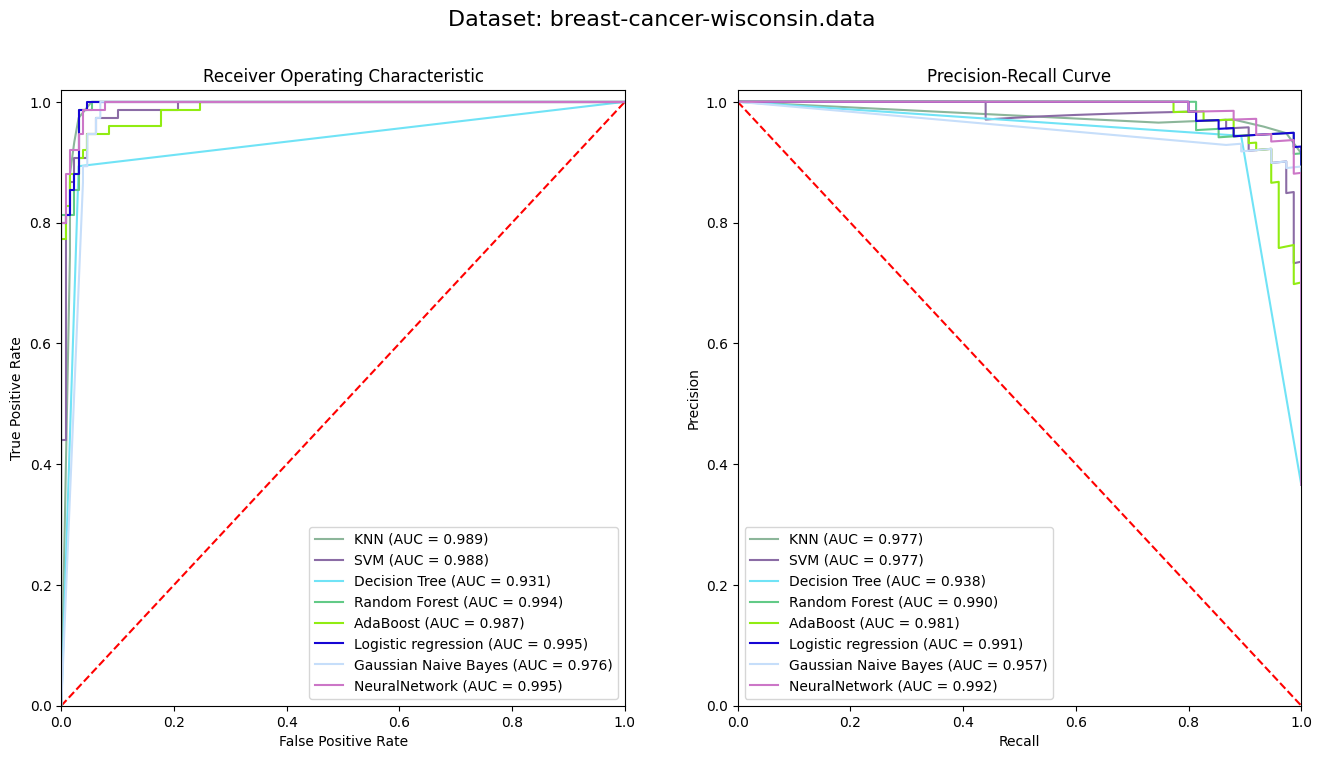

Dataset : wdbc.data
Class distributions:
1
B    357
M    212
Name: count, dtype: int64
Replaced all '?' to np.nan
No question marks found
No default test set, dataset splitted
Encoding X features
Normalized data by scaler: <class 'sklearn.preprocessing._data.MinMaxScaler'>
Encoding y label values
Training KNN ...
Training SVM ...
Training DecisionTree ...
Training RandomForest ...
Training AdaBoost ...


C:\Users\SANJEEV KUMAR\AppData\Roaming\Python\Python312\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Training LogisticRegression ...
Training GaussianNaiveBayes ...


C:\Users\SANJEEV KUMAR\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Training NeuralNetwork ...


C:\Users\SANJEEV KUMAR\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (315) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\SANJEEV KUMAR\AppData\Local\Temp\ipykernel_6748\1517101872.py:34: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(fpr, tpr, 'b', label = '%s (AUC = %0.3f)' % (clf_name,roc_auc), c=np.random.rand(3,))
C:\Users\SANJEEV KUMAR\AppData\Local\Temp\ipykernel_6748\1517101872.py:34: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(fpr, tpr, 'b', label = '%s (AUC = %0.3f)' % (clf_name,roc_auc), c=np.random.rand(3,))
C:\Users\SANJEEV KUMAR\AppData\Local\Temp\ipykernel_674

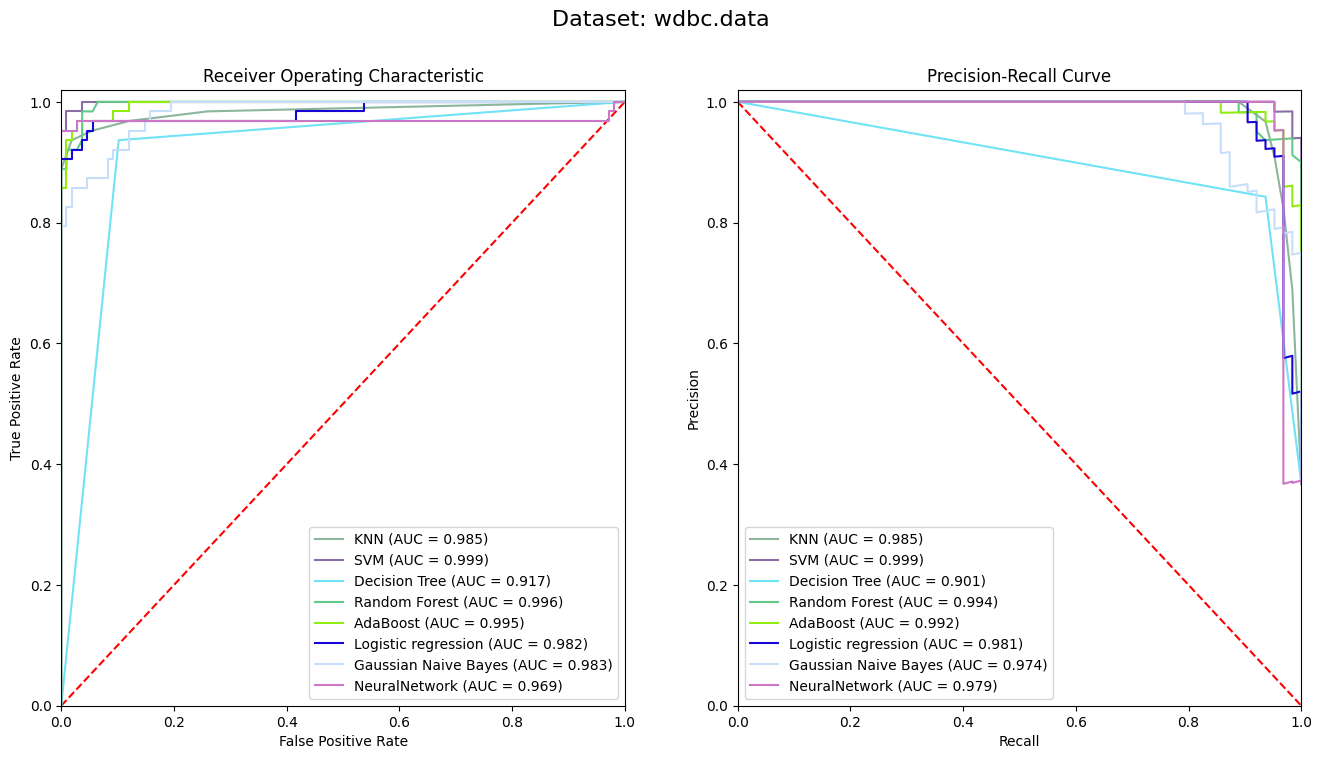

Dataset : wpbc.data
Class distributions:
1
N    148
R     46
Name: count, dtype: int64
Replaced all '?' to np.nan
No question marks found
No default test set, dataset splitted
Encoding X features
Normalized data by scaler: <class 'sklearn.preprocessing._data.MinMaxScaler'>
Encoding y label values
Training KNN ...
Training SVM ...
Training DecisionTree ...
Training RandomForest ...
Training AdaBoost ...


C:\Users\SANJEEV KUMAR\AppData\Roaming\Python\Python312\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Training LogisticRegression ...
Training GaussianNaiveBayes ...


C:\Users\SANJEEV KUMAR\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Training NeuralNetwork ...


C:\Users\SANJEEV KUMAR\AppData\Local\Temp\ipykernel_6748\1517101872.py:34: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(fpr, tpr, 'b', label = '%s (AUC = %0.3f)' % (clf_name,roc_auc), c=np.random.rand(3,))
C:\Users\SANJEEV KUMAR\AppData\Local\Temp\ipykernel_6748\1517101872.py:34: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(fpr, tpr, 'b', label = '%s (AUC = %0.3f)' % (clf_name,roc_auc), c=np.random.rand(3,))
C:\Users\SANJEEV KUMAR\AppData\Local\Temp\ipykernel_6748\1517101872.py:34: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(fpr, tpr, 'b', label = '%s (AUC = %0.3f)' % (clf_name,roc

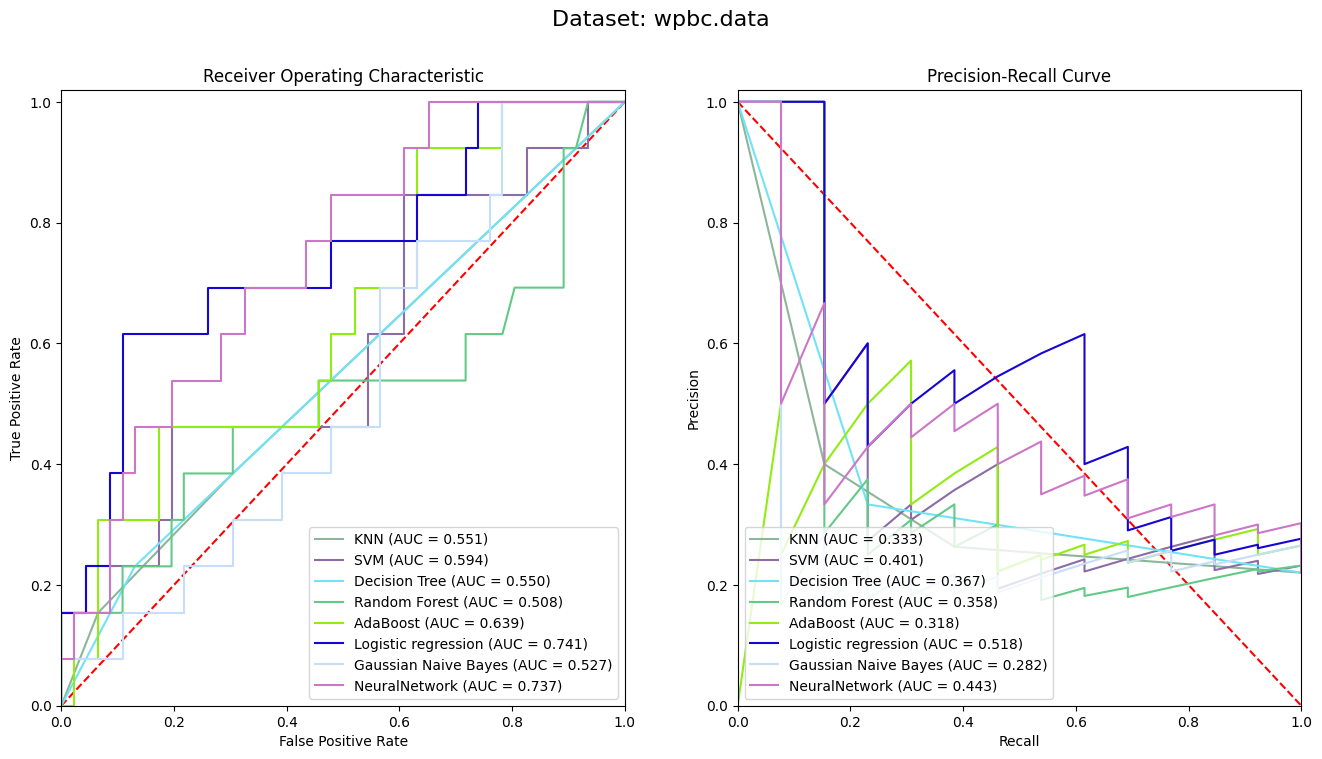

Dataset : australian.dat
Class distributions:
0
1    468
0    222
Name: count, dtype: int64
Replaced all '?' to np.nan
No question marks found
No default test set, dataset splitted
Encoding X features
Normalized data by scaler: <class 'sklearn.preprocessing._data.MinMaxScaler'>
Encoding y label values
Training KNN ...
Training SVM ...
Training DecisionTree ...
Training RandomForest ...
Training AdaBoost ...


C:\Users\SANJEEV KUMAR\AppData\Roaming\Python\Python312\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Training LogisticRegression ...
Training GaussianNaiveBayes ...


C:\Users\SANJEEV KUMAR\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Training NeuralNetwork ...


C:\Users\SANJEEV KUMAR\AppData\Local\Temp\ipykernel_6748\1517101872.py:34: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(fpr, tpr, 'b', label = '%s (AUC = %0.3f)' % (clf_name,roc_auc), c=np.random.rand(3,))
C:\Users\SANJEEV KUMAR\AppData\Local\Temp\ipykernel_6748\1517101872.py:34: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(fpr, tpr, 'b', label = '%s (AUC = %0.3f)' % (clf_name,roc_auc), c=np.random.rand(3,))
C:\Users\SANJEEV KUMAR\AppData\Local\Temp\ipykernel_6748\1517101872.py:34: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(fpr, tpr, 'b', label = '%s (AUC = %0.3f)' % (clf_name,roc

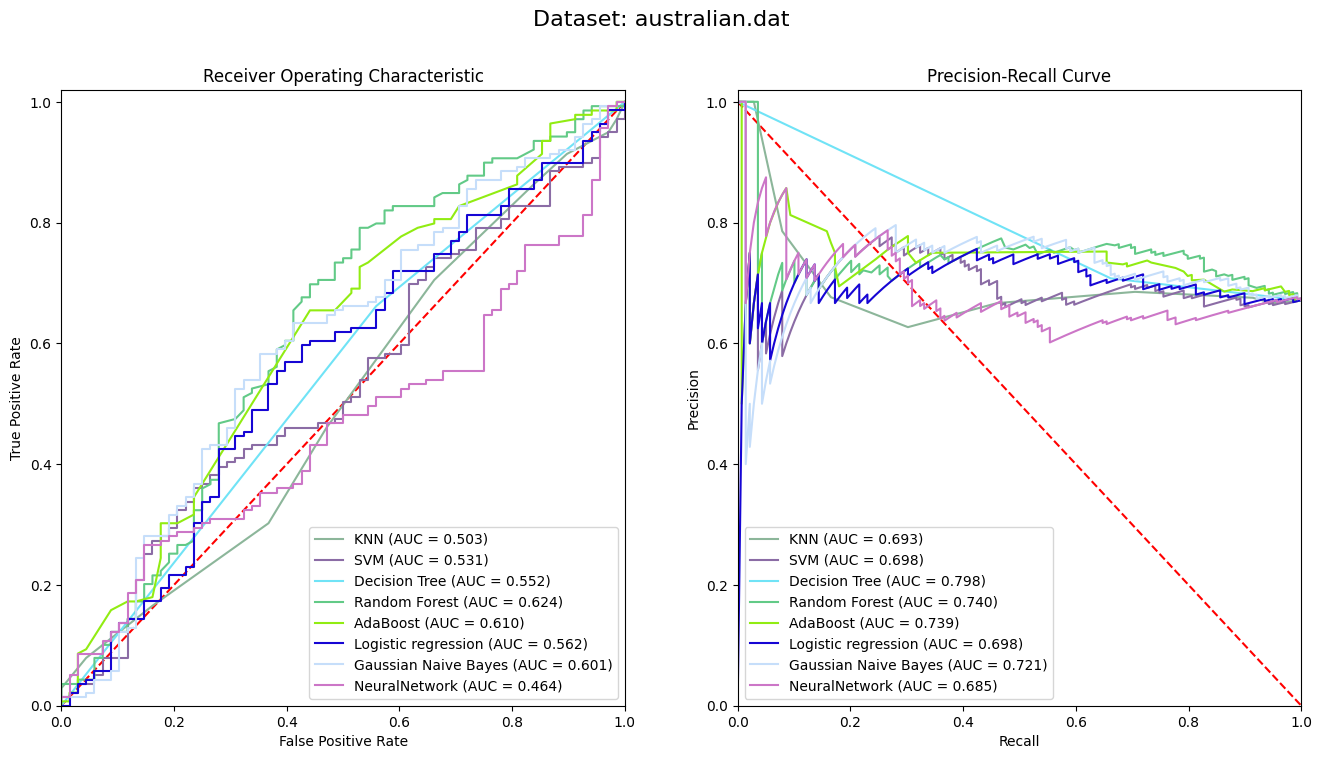

Dataset : german.data-numeric
Class distributions:
24
1    700
2    300
Name: count, dtype: int64
Replaced all '?' to np.nan
No question marks found
No default test set, dataset splitted
Encoding X features
Normalized data by scaler: <class 'sklearn.preprocessing._data.MinMaxScaler'>
Encoding y label values
Training KNN ...
Training SVM ...
Training DecisionTree ...
Training RandomForest ...
Training AdaBoost ...


C:\Users\SANJEEV KUMAR\AppData\Roaming\Python\Python312\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Training LogisticRegression ...
Training GaussianNaiveBayes ...


C:\Users\SANJEEV KUMAR\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Training NeuralNetwork ...


C:\Users\SANJEEV KUMAR\AppData\Local\Temp\ipykernel_6748\1517101872.py:34: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(fpr, tpr, 'b', label = '%s (AUC = %0.3f)' % (clf_name,roc_auc), c=np.random.rand(3,))
C:\Users\SANJEEV KUMAR\AppData\Local\Temp\ipykernel_6748\1517101872.py:34: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(fpr, tpr, 'b', label = '%s (AUC = %0.3f)' % (clf_name,roc_auc), c=np.random.rand(3,))
C:\Users\SANJEEV KUMAR\AppData\Local\Temp\ipykernel_6748\1517101872.py:34: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(fpr, tpr, 'b', label = '%s (AUC = %0.3f)' % (clf_name,roc

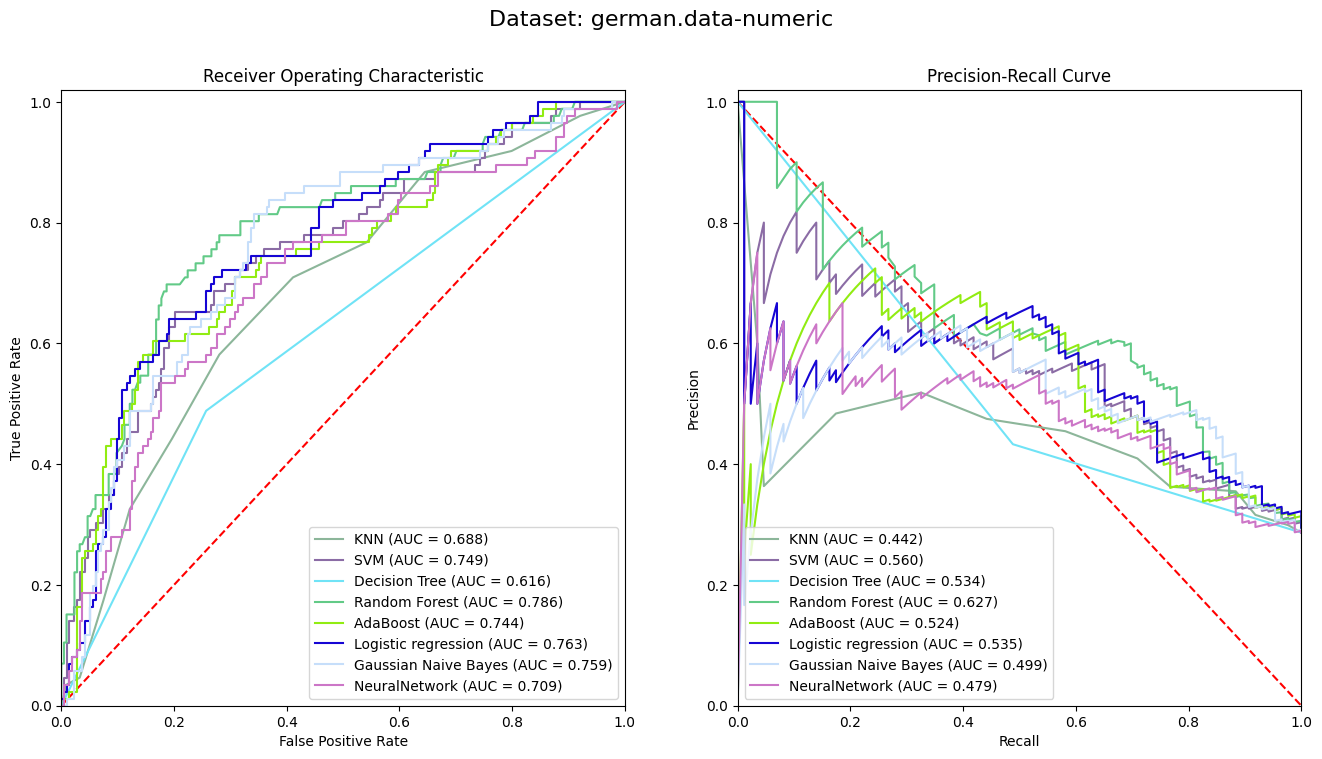

Dataset : Faults.NNA
Class distributions:
class
33    673
32    402
29    391
28    190
27    158
30     72
31     55
Name: count, dtype: int64
Replaced all '?' to np.nan
No question marks found
No default test set, dataset splitted
Encoding X features
Normalized data by scaler: <class 'sklearn.preprocessing._data.MinMaxScaler'>
Encoding y label values
Training KNN ...
Training SVM ...
Training DecisionTree ...
Training RandomForest ...


In [ ]:
# %%time
files = [file1,file2,file3,file3_2,file3_3,file4,file5,file6,file7,file8,file9,file10]
dfs = [df1,df2,df3,df3_2,df3_3,df4,df5,df6,df7,df8,df9,df10]
dfs_test = [None,None,None,None,None,None,None,None,df7_test,None,None,None]

clfs_all_roc_scores = dict()
clfs_all_pr_scores = dict()

# i = 0
# files=[files[i]]
# dfs = [dfs[i]]
# dfs_test = [dfs_test[i]]

for file,df,df_test in zip(files,dfs,dfs_test):
    roc_scores, pr_scores = make_classification(file, df, df_test)
    for k,v in roc_scores.items():
        if k not in clfs_all_roc_scores:
            clfs_all_roc_scores[k] = list()
        clfs_all_roc_scores[k].append(v)
    for k,v in pr_scores.items():
        if k not in clfs_all_pr_scores:
            clfs_all_pr_scores[k] = list()
        clfs_all_pr_scores[k].append(v)    

In [ ]:
for k,v in clfs_all_roc_scores.items():
    print('%s-roc:'%k,["%.3f"%i for i in v])

In [ ]:
for k,v in clfs_all_pr_scores.items():
    print('%s-pr:'%k,["%.3f"%i for i in v])

In [ ]:
for k,v in clfs_all_roc_scores.items():
    print('%s avg roc_auc: %.2f, avg pr_auc: %.2f'%(k,np.mean(v),np.mean(clfs_all_pr_scores[k])))